<a href="https://colab.research.google.com/github/AntoninaKOR/training-code-ml/blob/main/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 34.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=cdf2c21c1beb172ad4c9dc73937547b8f7886043977aeadfb17df98a0162e3d7
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 41.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.21.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.1 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.2.1 which is incompatible.


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 5.5 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import hf_hub_download
import pandas as pd
import matplotlib
import numpy as np
import nltk
import seaborn
import sklearn
import gensim
import wordcloud
import textblob
import spacy
import gensim
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from nltk.corpus import stopwords
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier, Pool

#Скачивание датасета

In [ ]:
dataset = pd.read_csv(
    hf_hub_download(repo_id='MonoHime/ru_sentiment_dataset', filename="datasets.csv", repo_type="dataset"), index_col=0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


datasets.csv:   0%|          | 0.00/307M [00:00<?, ?B/s]

Labels meaning

0: NEUTRAL

1: POSITIVE

2: NEGATIVE

In [ ]:
dataset

,text,sentiment
43956,Развода на деньги нет\nНаблюдаюсь в Лайфклиник...,1
17755,Отель выбрали потому что рядом со стадионом. О...,0
20269,"Вылечили\nГноился с рождения глазик, в поликли...",1
16648,Хорошее расположение.С вокзала дошли пешком.Но...,0
27879,"Отличное месторасположение,прекрасный вид,особ...",1
...,...,...
22100,"Мой юбилей я отмечал в ресторане "" Астория "" ....",2
2326,"Отлично встретили, разместили в роскошном номе...",1
10478,Была в Васаби на ст. метро Сенная . Во первых...,0
4028,Ребята не стоит смотреть этот фильм. Вы молоды...,0


#EDA

Посмотрим на распределение по лэйблам.

<Axes: >

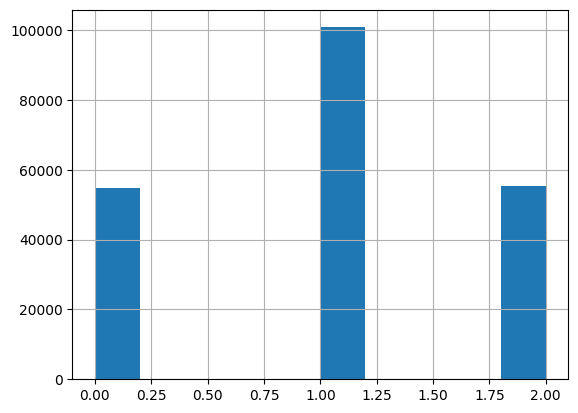

In [ ]:
dataset.sentiment.hist()

Данных с лэйблом 1 больше примерно в 2 раза.

## Analyzing text statistics

###Длина текстов

<Axes: >

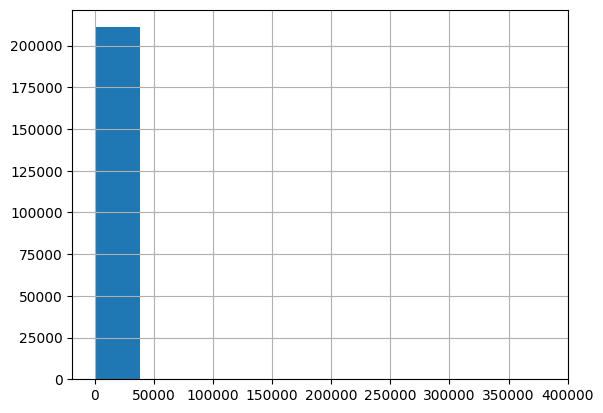

In [ ]:
dataset['text'].str.len().hist()

In [ ]:
dataset.text.str.len().max()

381498

In [ ]:
dataset[dataset.text.str.len()>50000].shape[0]

19

Почти все тексты длиной не больше 50000.

Посмотрим гистограмму в меньшем диапазоне

<Axes: >

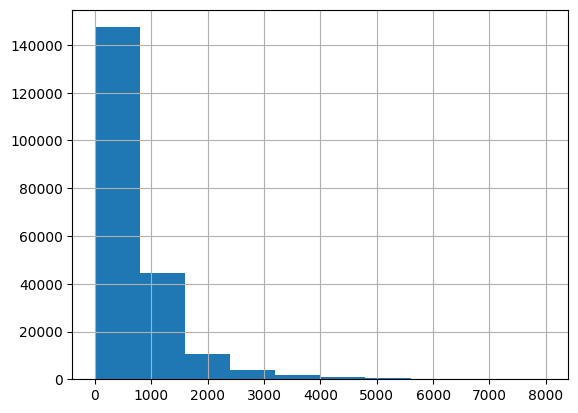

In [ ]:
dataset['text'].str.len().hist(range=(0, 8000))

Больше всего данных от 0 до 1000.

###Количество слов

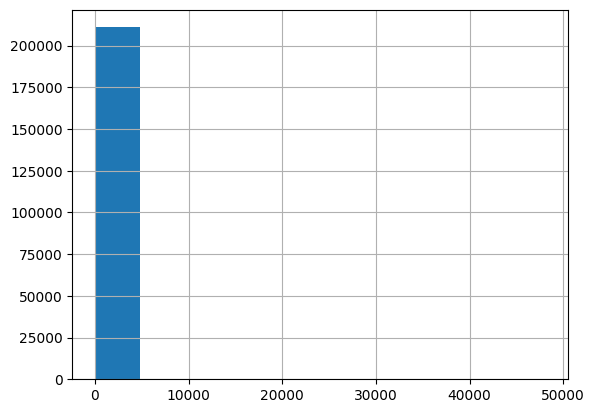

In [ ]:
def plot_word_number_histogram(text, range=None):
    text.str.split().\
        map(lambda x: len(x)).\
        hist(range=range)
plot_word_number_histogram(dataset['text'])

Количество слов в большинстве текстов не больше 10000.

Количество данных, у которых количество слов больше 10000:

In [ ]:
dataset[dataset.text.str.split().map(lambda x: len(x))>10000].shape[0]

10

Посмотрим гистограмму от 0 до 1250

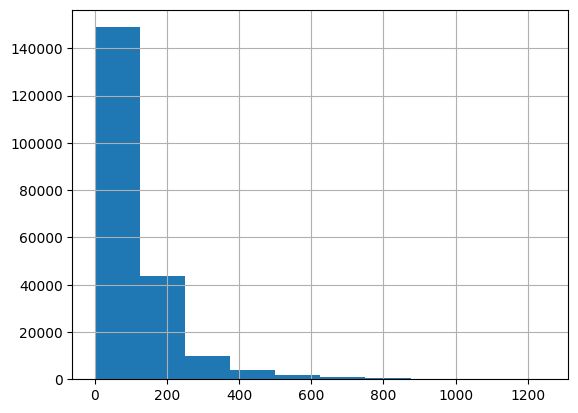

In [ ]:
plot_word_number_histogram(dataset['text'], (0, 1250))

###Средняя длина слов

<Axes: >

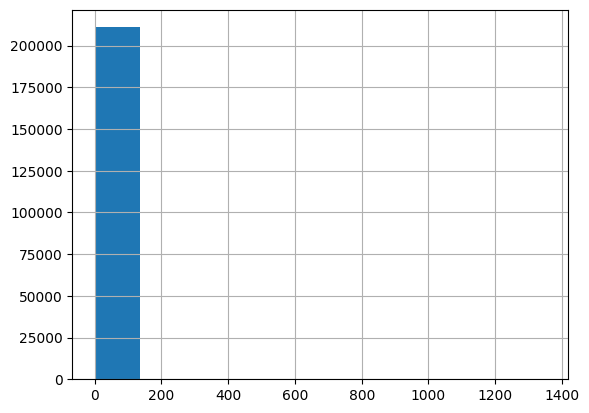

In [ ]:
dataset['text'].str.split().\
   apply(lambda x : [len(i) for i in x]).\
   map(lambda x: np.mean(x)).hist()

Большинство данных имеет среднюю длину слов не больше 200.

In [ ]:
dataset[dataset['text'].str.split().\
   apply(lambda x : [len(i) for i in x]).\
   map(lambda x: np.mean(x))>200].shape[0]

3

Посмотрим на диаграмму от 0 до 12

<Axes: >

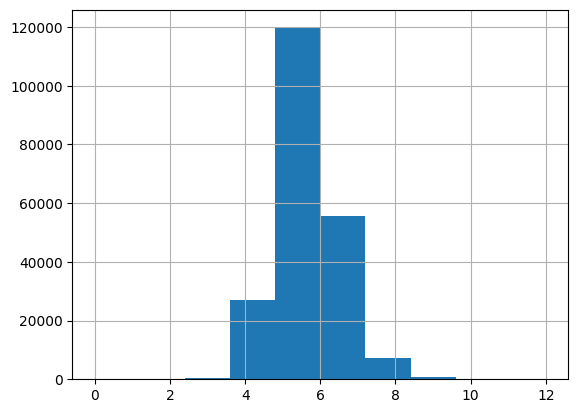

In [ ]:
dataset['text'].str.split().\
   apply(lambda x : [len(i) for i in x]).\
   map(lambda x: np.mean(x)).hist(range=(0,12))

В срднем слова длиной от 5 до 7.

##Стоп-слова

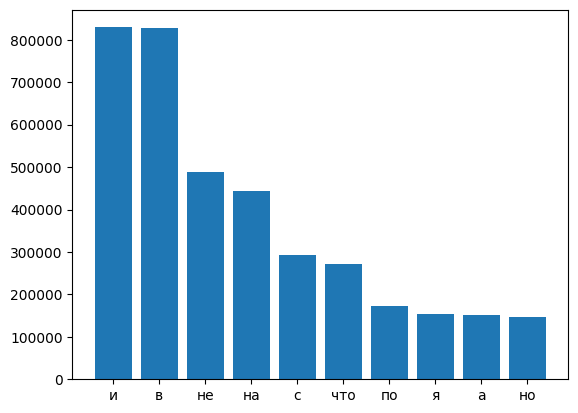

In [ ]:
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('russian'))

    text= dataset.text.str.lower().str.split()
    text=text.values.tolist()
    corpus=[word for i in text for word in i]
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
    # 10 самых использующихся стопслов
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
    x,y=zip(*top)
    plt.bar(x,y)
plot_top_stopwords_barchart(dataset.text)

Частоиспользуемые слова без стопслов

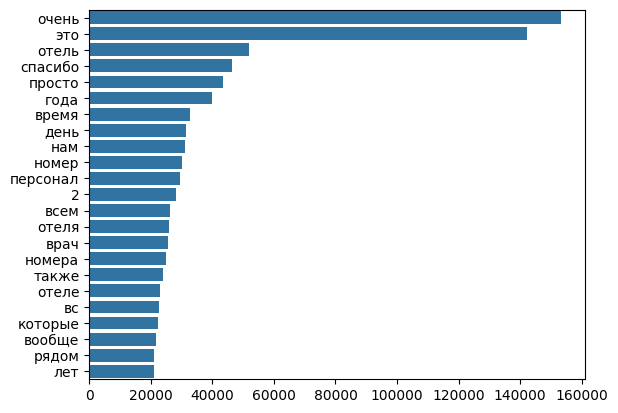

In [ ]:
import seaborn as sns
from collections import  Counter
from string import punctuation
import re
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('russian'))

    text= text.str.lower()
    text = text.apply(lambda x: re.sub('[^а-я А-Я 0-9-]+', '', x))
    text=text.str.split()
    text=text.values.tolist()
    corpus=[word for i in text for word in i]

    #counter возвращает словарь слово: число повторений слова в тексте
    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:100]:
      #в punctuation нет — и –, поэтому мы отдельно напишем условия про них
        if (word not in stop and word not in punctuation and word!='—' and word!='–'):
            x.append(word)
            y.append(count)

    sns.barplot(x=y,y=x)
plot_top_non_stopwords_barchart(dataset.text)

Заметим, что осталось также довольно много слов, которые можно считать стоп-словами.

Теперь нарисуем диаграммы для каждого из лэйблов: 0, 1, 2.

Для нейтральных текстов:

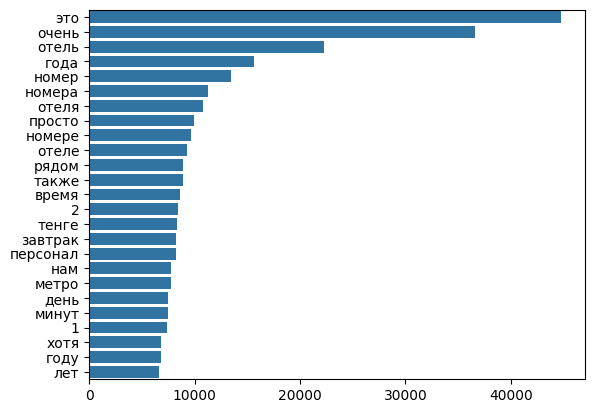

In [ ]:
plot_top_non_stopwords_barchart(dataset[dataset.sentiment==0].text)

Позитивных:

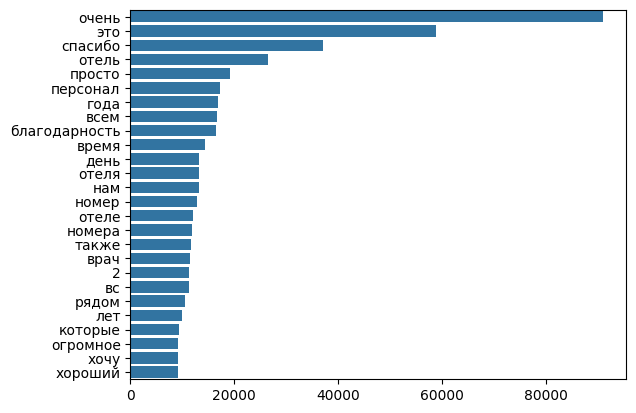

In [ ]:
plot_top_non_stopwords_barchart(dataset[dataset.sentiment==1].text)

Заметим, стандарные позитивные слова: спасибо, хороший, благодарность.

Негативныx:

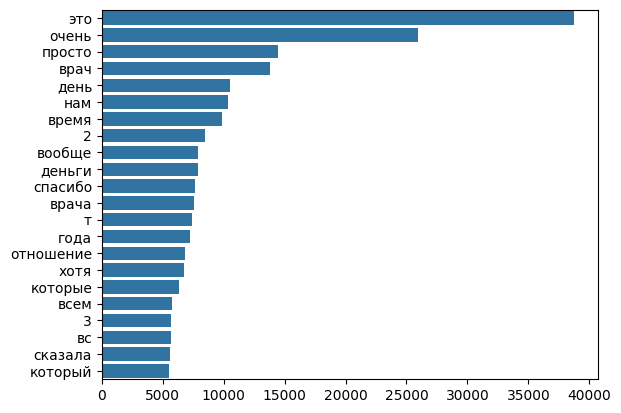

In [ ]:
plot_top_non_stopwords_barchart(dataset[dataset.sentiment==2].text)

Интересно, что в негативных текстах также есть "спасибо".

Заметим, что по диаграммам нет сильной разницы в популярных словах по лэйблам.

#Тематическое моделирование текстовых данных

Тематическое моделирование — это подход анализа текстовых данных, направленный на выявление скрытых тематических структур в коллекции документов. Оно позволяет автоматически определить, какие темы присутствуют в наборе текстов, и какие слова характеризуют каждую тему. Это важно для эффективного описания и интерпретации больших объемов текстовой информации.

##Источники:


1.   https://habr.com/ru/companies/otus/articles/757010/
2.   https://medium.com/@sujathamudadla1213/difference-between-lda-and-lsa-f7fefa6b4bfd
3.   https://medium.com/@sujathamudadla1213/explain-in-detail-lsa-in-natural-language-processing-a9870f8994ed
4.   https://towardsdatascience.com/latent-semantic-analysis-intuition-math-implementation-a194aff870f8
5.   https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
6.   https://sysblok.ru/nlp/kak-sdelat-tematicheskoe-modelirovanie/
7. https://towardsdatascience.com/understanding-topic-coherence-measures-4aa41339634c
8.   https://www.baeldung.com/cs/topic-modeling-coherence-score


##Latent Dirichlet Allocation (LDA)

Достоинства:


1.   Скрытые темы: LDA позволяет выявить скрытые темы в текстовых данных, которые могут быть неочевидны при поверхностном чтении.

2.  Обобщение: Модель обобщает документы на уровне тем, что полезно для анализа и категоризации больших объемов текстов.

3.  Интерпретируемость: Результаты LDA часто легко интерпретировать, так как каждая тема связана с набором характерных слов.

Недостатки:


1.   Выбор числа тем: Определение оптимального количества тем может быть сложной задачей и требует экспериментов.

2.   Чувствительность к параметрам: Результаты могут сильно зависеть от исходных параметров и инициализации.

3.   Подготовка данных: Необходима тщательная предобработка данных, включая удаление стоп-слов и другие шаги.




##Неотрицательная матричная факторизация (NMF)

Основная идея NMF заключается в следующем:

1. Пусть у нас есть матрица V размерности m x n, где m — количество слов, n — количество документов.

2. NMF пытается найти две матрицы W и H размерности m x k и k x n, где k — количество тем (факторов), такие что V ≈ WH.

3. Матрица W содержит "слова-темы" и показывает, какие слова характеризуют каждую тему.

4. Матрица H содержит "темы-документы" и показывает, насколько каждая тема присутствует в каждом документе.

Достоинства:


1.   Интерпретируемость: NMF, благодаря неотрицательности элементов матриц, обеспечивает более простую интерпретацию. Элементы матриц W и H могут быть прямо связаны с важностью слов и тем.

2.   Неотрицательность: Важным преимуществом NMF является неотрицательность, что делает его более подходящим для некоторых типов данных, таких как отзывы с оценками, где все значения положительны.

3.   Число тем: В NMF число факторов  требует настройки, но может быть более прямолинейным, так как оно влияет на размерности матриц.



##Latent Semantic Analysis (LSA)

LSA работает следующим образом:

1. Построение матрицы "слова-документы" или другой матрицы, представляющей текстовые данные.

2. Применение сингулярного разложения к матрице для снижения размерности.

3. Выделение наиболее важных сингулярных значений, которые представляют латентные семантические "факторы".

4. Анализ этих факторов для выявления скрытых тематик.

##Реализация

Остановимся на LDA из-за лучшей интерпретируемости.

###Подготовка данных

Анализ мы проводили, используя стоп-слова из nltk. И по диаграммам видно, что там слова "что" и т.д. не вохят в список стоп-слов. Поэтому возьмем стоп-слова из https://raw.githubusercontent.com/dhhse/dh2020/master/data/stop_ru.txt.

In [ ]:
from nltk.tokenize import word_tokenize
from nltk import download as nltk_download
nltk_download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!wget https://raw.githubusercontent.com/dhhse/dh2020/master/data/stop_ru.txt
with open ("stop_ru.txt", "r") as stop_ru:
    rus_stops = [word.strip() for word in stop_ru.readlines()]
punctuation = '!\"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~—»«...–'
filter = rus_stops + list (punctuation)

--2024-02-29 10:17:07--  https://raw.githubusercontent.com/dhhse/dh2020/master/data/stop_ru.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5823 (5.7K) [text/plain]
Saving to: ‘stop_ru.txt’

stop_ru.txt         100%[===================>]   5.69K  --.-KB/s    in 0s      

2024-02-29 10:17:07 (64.4 MB/s) - ‘stop_ru.txt’ saved [5823/5823]



In [ ]:
from pymorphy2 import MorphAnalyzer
#лемматизация
parser = MorphAnalyzer()

Обрабатываем текст

In [ ]:
def preprocess(input_text):
    #приводим к нижнему регистру
    text = input_text.lower()
    #разделяем на токены
    tokenized_text = word_tokenize(text)
    #убираем стоп-слова и знаки препинания
    clean_text = [word for word in tokenized_text if word not in filter]
    #мое озу гугл коллаба не тянет лемматизацию, строчку ниже надо раскомментировать и возвращать ее результат
    #lemmatized_text = [parser.parse(word)[0].normal_form for word in clean_text]

    return clean_text
dataset["text_processed"] = dataset["text"].map(preprocess)

In [ ]:
gensim_dictionary = gensim.corpora.Dictionary(dataset["text_processed"])
#убираем слова, которые встречаются в более чем 0.1 долях текстов и менее чем в 20 текстах
gensim_dictionary.filter_extremes(no_above=0.1, no_below=20)
#ужимаем словарь, убирая пропуски
gensim_dictionary.compactify()

In [ ]:
corpus = [gensim_dictionary.doc2bow(text) for text in dataset['text_processed']]

###Модель

Определяем модель LDA.

In [ ]:
lda = gensim.models.LdaMulticore(corpus,
                                 num_topics=10,
                                 id2word=gensim_dictionary,
                                 passes=10, random_state=6457)

###Визуализация

Посмотрим топики

In [ ]:
lda.print_topics()

[(0,
  '0.007*"тенге" + 0.005*"казахстан" + 0.005*"ао" + 0.005*"казахстана" + 0.004*"2016" + 0.004*"области" + 0.004*"республики" + 0.004*"рк" + 0.003*"развития" + 0.003*"млрд"'),
 (1,
  '0.010*"ресторан" + 0.009*"меню" + 0.008*"место" + 0.008*"вкусно" + 0.008*"обслуживание" + 0.007*"интерьер" + 0.007*"кухня" + 0.007*"цены" + 0.007*"понравилось" + 0.005*"ресторане"'),
 (2,
  '0.013*"отеля" + 0.011*"отеле" + 0.010*"номере" + 0.009*"завтрак" + 0.008*"метро" + 0.006*"завтраки" + 0.006*"расположение" + 0.006*"минут" + 0.005*"n" + 0.005*"хороший"'),
 (3,
  '0.009*"машина" + 0.007*"авто" + 0.007*"автомобиль" + 0.005*"машину" + 0.005*"машины" + 0.003*"красавчик" + 0.003*"км" + 0.003*"салон" + 0.003*"машине" + 0.003*"стоит"'),
 (4,
  '0.011*"ресторана" + 0.010*"ресторане" + 0.008*"обслуживание" + 0.008*"гости" + 0.008*"ресторан" + 0.008*"довольны" + 0.008*"уровне" + 0.008*"остались" + 0.007*"рождения" + 0.006*"зал"'),
 (5,
  '0.005*"случае" + 0.005*"деньги" + 0.004*"вопрос" + 0.003*"1" + 0.003

##Варианты улучшения

1. Подбор рпараметров. Пример подборки параметра количества тем ниже:

In [ ]:
'''
def coherence_score(dictionary, corpus, texts, max=10, start=3, step=2, measure="c_uci"):
    coherence_values = []
    for num_topics in range(start, max, step):
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary,
                                           passes=10, num_topics=num_topics,
                                           random_state=6457)
        coherencemodel = CoherenceModel(model=model, texts=texts,
                                        dictionary=dictionary,
                                        coherence=measure)
        coherence_values.append(coherencemodel.get_coherence())
    x = range(start, max, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel(measure + "score")
    plt.legend(("coherence_score"), loc='best')
    plt.show()
coherence_score(dictionary=gensim_dictionary, corpus=corpus, texts=dataset["text_processed"], start=3, max=10, step=2)
'''

2. Лемматизация. У меня не хватило мощности компьютера для хорошей лемматизации. По темам видно, что во многие темы попали слова с просто разными окончаниями, что не случилось бы при лемматизации.Можно поробовать советы из https://habr.com/ru/articles/503420/ по ускорению.
3. Визуализация расстояния между темами. Это полезная встроенная фунция, которая помогает посмотреть на то, как распределились темы.
4. Также стоит построить график того, как связаны лэйблф и темы, сгенерированные LDA.

#Обучение классификатора

##Метрика

За метрику возьмем точность (accuracy), так как у нас не специфичная задачаи мы в общем пытаемся поднять процент TP и TN.

##Работа с данными

Разделение данных на train/val/test части

In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(dataset['text'], dataset['sentiment'], test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Из типо object приводим к типу DataFrame, чтобы у колонки было имя.

In [ ]:
X_train = pd.DataFrame(X_train, columns=['text'])
X_test = pd.DataFrame(X_test, columns=['text'])
X_valid = pd.DataFrame(X_valid, columns=['text'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train_pool = Pool(
    data=X_train,
    label=y_train,
    text_features=['text']
)

valid_pool = Pool(
    data=X_valid,
    label=y_valid,
    text_features=['text']
)

test_pool = Pool(
    data=X_test,
    label=y_test,
    text_features=['text']
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##Модель

Функция обучения

In [ ]:
def fit_model(train_pool, test_pool, task_type='GPU',iterations=5000,\
        eval_metric='Accuracy',  **kwargs):
    model = CatBoostClassifier(
        task_type=task_type,
        iterations=iterations,
        eval_metric='Accuracy',
        od_type='Iter',
        od_wait=500,
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=test_pool,
        verbose=100,
        plot=True,
        use_best_model=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Пробная модель

In [ ]:
model = fit_model(
    train_pool, valid_pool, task_type='GPU',\
    learning_rate=0.35,
    tokenizers=[
        {
            'tokenizer_id': 'Sense', #тк делаем анализ тональности
            'separator_type': 'BySense', #тк делаем анализ тональности
            'lowercasing': 'True',
            'token_types':['Word', 'Number', 'SentenceBreak'],
            'sub_tokens_policy':'SeveralTokens'
        }
    ],
    dictionaries = [
        {
            'dictionary_id': 'Word',
            'max_dictionary_size': '200000'
        }
    ],
    feature_calcers = [
        'BoW:top_tokens_count=20000'
    ]
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5272724	test: 0.5256884	best: 0.5256884 (0)	total: 51.6ms	remaining: 1m 43s
100:	learn: 0.7121168	test: 0.6990379	best: 0.6990379 (100)	total: 1.66s	remaining: 31.1s
200:	learn: 0.7376869	test: 0.7159818	best: 0.7163136 (193)	total: 3.05s	remaining: 27.3s
300:	learn: 0.7535093	test: 0.7256031	best: 0.7260771 (297)	total: 4.42s	remaining: 24.9s
400:	learn: 0.7651608	test: 0.7297028	best: 0.7298450 (393)	total: 6.66s	remaining: 26.6s
500:	learn: 0.7738817	test: 0.7343476	best: 0.7346794 (499)	total: 8.82s	remaining: 26.4s
600:	learn: 0.7810542	test: 0.7374520	best: 0.7374757 (593)	total: 10.2s	remaining: 23.8s
700:	learn: 0.7879346	test: 0.7384473	best: 0.7384473 (688)	total: 11.6s	remaining: 21.5s
800:	learn: 0.7941513	test: 0.7399403	best: 0.7401299 (798)	total: 13s	remaining: 19.5s
900:	learn: 0.7999257	test: 0.7413621	best: 0.7422153 (866)	total: 14.4s	remaining: 17.6s
1000:	learn: 0.8051630	test: 0.7425470	best: 0.7433765 (977)	total: 15.9s	remaining: 15.9s
1100:	learn: 

На gpu модель при параметрах max_dictionary_size =50000, top_tokens_count=10000 училасть 44 секунды на 1000 итерациях.
На cpu больше 4 минут обрабатывается 2 эпохи. Все обучение заняло 1h 5m 33s. На качестсво модели обучение с ускорителем или без не влияет, но обязательно для сравнения надо закрепить seed. Точность оказалась примерно 0.74.


Далеее при учеличении max_dictionary_size, top_tokens_count и числа итераций получилось повысить точность до 0.757

In [ ]:
y_proba_cb = model.predict_proba(test_pool)
y_pred = np.argmax(y_proba_cb, axis=1)
df_test_pred = model.predict(test_pool)
acc = model.score(test_pool)
print(f"CatBoost model accuracy: {acc}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CatBoost model accuracy: 0.7475946727333049


##Подбор гиперпараметров

Подберим одни из самых важный параметров для дерева.

In [ ]:
parameters = {'depth'         : [4,7,9, 11, 14],
                 'learning_rate' : [0.02,0.03,0.04],
                  'iterations'    : [1000, 2000, 3000, 5000]
                 }

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Определяем модель

In [ ]:
model = CatBoostClassifier(devices='GPU', text_features=['text'], tokenizers=[
        {
            'tokenizer_id': 'Sense', #тк делаем анализ тональности
            'separator_type': 'BySense', #тк делаем анализ тональности
            'lowercasing': 'True',
            'token_types':['Word', 'Number', 'SentenceBreak'],
            'sub_tokens_policy':'SeveralTokens'
        }
    ],
    dictionaries = [
        {
            'dictionary_id': 'Word',
            'max_dictionary_size': '50000'
        }
    ],
    feature_calcers = [
        'BoW:top_tokens_count=10000'
    ]
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Дальнейший код не получилось нормально проверишь из-за ограничений по gpu в гугл коллабе и дедлайна.

In [ ]:
Grid_CBC = GridSearchCV(estimator=model, param_grid = parameters, cv = 2)
Grid_CBC.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be remo

Выходные данные были обрезаны до нескольких последних строк (5000).
157:	learn: 0.8576624	total: 2m 54s	remaining: 15m 27s
158:	learn: 0.8571858	total: 2m 55s	remaining: 15m 27s
159:	learn: 0.8566497	total: 2m 57s	remaining: 15m 30s
160:	learn: 0.8562082	total: 2m 58s	remaining: 15m 28s
161:	learn: 0.8556083	total: 2m 59s	remaining: 15m 27s
162:	learn: 0.8551572	total: 3m	remaining: 15m 25s
163:	learn: 0.8546452	total: 3m 1s	remaining: 15m 23s
164:	learn: 0.8541875	total: 3m 2s	remaining: 15m 22s
165:	learn: 0.8536955	total: 3m 3s	remaining: 15m 20s
166:	learn: 0.8533436	total: 3m 4s	remaining: 15m 19s
167:	learn: 0.8529844	total: 3m 5s	remaining: 15m 17s
168:	learn: 0.8525523	total: 3m 6s	remaining: 15m 15s
169:	learn: 0.8520073	total: 3m 7s	remaining: 15m 15s
170:	learn: 0.8515577	total: 3m 9s	remaining: 15m 16s
171:	learn: 0.8512167	total: 3m 10s	remaining: 15m 15s
172:	learn: 0.8506872	total: 3m 11s	remaining: 15m 15s
173:	learn: 0.8500831	total: 3m 12s	remaining: 15m 13s
174:	lear

In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

Потом надо обучить модель с лучшими параметрами.

##Варианты улучшения

1. Сбалансировать классы, используя compute_class_weight
. См. https://habr.com/ru/articles/655517/
2. Попробовать другие библиотеки с деревьями.
3. Включить модель в ансамбль.
4. Попробовать другие методы обработки текста, например, не BoW
5. Попробовать сначала извлекать какие-то фичи из текста, а потом уже подавать это в дерево решений.
6. Попробовать подобрать еще лучшие гиперпараметры. И делать это быстрее с помощью https://habr.com/ru/articles/721154/